## My Tokenizer

This is my Tokenizer

In [18]:
mytokenizer = "Hello Tokenizer !"

## Tutorial Andrej

In [19]:
[ord(x) for x in mytokenizer]

[72,
 101,
 108,
 108,
 111,
 32,
 84,
 111,
 107,
 101,
 110,
 105,
 122,
 101,
 114,
 32,
 33]

In [20]:
[hex(b) for b in bytes(mytokenizer, 'utf-8')]

['0x48',
 '0x65',
 '0x6c',
 '0x6c',
 '0x6f',
 '0x20',
 '0x54',
 '0x6f',
 '0x6b',
 '0x65',
 '0x6e',
 '0x69',
 '0x7a',
 '0x65',
 '0x72',
 '0x20',
 '0x21']

### How it work

In [21]:
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
tokens = text.encode('utf-8') # bytes
tokens = list(map(int, tokens))
print(text)
print('length:', len(text))
print('-' * 200)
print(tokens)
print('length:', len(tokens))

Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.
length: 533
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148,

In [22]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

# stats = get_stats(tokens)
# print('length:', len(stats))
# print(stats)
# print(sorted(((v, k) for k, v in stats.items()), reverse=True)) # sorted by frequency

def merge(ids, pair, index):
    new_ids = []
    i = 0
    while i < len(ids):
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i + 1] == pair[1]:
            new_ids.append(index)
            i += 2
        else:
            new_ids.append(ids[i])
            i += 1
    return new_ids

# print('merge:', merge([5, 6, 6, 7, 9, 1], (6, 7), 99))

# tokens2 = merge(tokens, top_pair, 256)
# print('length:', len(tokens2))
# print('tokens:', tokens2)

# ---------

vocab_size = 276 # the desired final vocabulary size
num_merges = vocab_size - 256
ids = list(tokens) # copy so we wont modify the original tokens

merges = {}
for i in range(num_merges):
    stats = get_stats(ids)
    pairs = max(stats, key=stats.get)
    index = 256 + i
    print('merging:', pairs, '->', index)
    ids = merge(ids, pairs, index)
    merges[pairs] = index



merging: (101, 32) -> 256
merging: (240, 159) -> 257
merging: (226, 128) -> 258
merging: (105, 110) -> 259
merging: (115, 32) -> 260
merging: (97, 110) -> 261
merging: (116, 104) -> 262
merging: (257, 133) -> 263
merging: (257, 135) -> 264
merging: (97, 114) -> 265
merging: (239, 189) -> 266
merging: (258, 140) -> 267
merging: (267, 264) -> 268
merging: (101, 114) -> 269
merging: (111, 114) -> 270
merging: (116, 32) -> 271
merging: (259, 103) -> 272
merging: (115, 116) -> 273
merging: (261, 100) -> 274
merging: (32, 262) -> 275


In [23]:
print("tokens length:", len(tokens))
print("ids length:", len(ids))
print(f"compression ratio: {len(tokens) / len(ids):.2f}X")

tokens length: 616
ids length: 451
compression ratio: 1.37X


### Decoding


In [24]:
vocab = { index: bytes([index]) for index in range(256) }
for (p0, p1), index in merges.items():
    vocab[index] = vocab[p0] + vocab[p1]

def decode(ids):
    tokens = b"".join([vocab[index] for index in ids])
    text = tokens.decode('utf-8', errors='replace')
    return text

print(decode([129]))


�


### Enconding

In [31]:
def encode(text):
    tokens = list(text.encode('utf-8'))

    while len(tokens) > 2:
        stats = get_stats(tokens)
        min_pair = min(stats, key=lambda p: merges.get(p, float('inf')))
        if min_pair not in merges:
            break
        index = merges[min_pair]
        tokens = merge(tokens, min_pair, index)
    return tokens

print(encode(mytokenizer))

[72, 101, 108, 108, 111, 32, 84, 111, 107, 101, 110, 105, 122, 269, 32, 33]


Not all token sequences have valid UTF-8 encodings so you might not have the same resulte if you decode(encode(A_STRING))

### Tiktoken
Forced splits using regex patterns (GPT 2)

In [26]:
import regex as re
gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

print(re.findall(gpt2pat, "dog dog. dog! dog123 dog\n"))

['dog', ' dog', '.', ' dog', '!', ' dog', '123', ' dog', '\n']


The regex don't take everything in count, for example ' is hard code and don't take ’ version or capitalize :

In [27]:
print(re.findall(gpt2pat, "dog's dog’s DOG'S dog'S"))
print('-' * 20)
gpt4pat = re.compile(r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}++|\p{N}{1,3}+| ?[^\s\p{L}\p{N}]++[\r\n]*+|\s++$|\s*[\r\n]|\s+(?!\S)|\s""")
print(re.findall(gpt4pat, "dog's dog’s DOG'S dog'S"))

['dog', "'s", ' dog', '’', 's', ' DOG', "'", 'S', ' dog', "'", 'S']
--------------------
['dog', "'s", ' dog', '’s', ' DOG', "'S", ' dog', "'S"]


We can see that Tiktoken for GPT-2 doesn't take the space in the merge

In [28]:
import tiktoken

# GPT-2
encode = tiktoken.get_encoding("gpt2")
print(encode.encode("     Hello Tiktoken!"))
print(encode.encode("dog's dog’s DOG'S dog'S"))

print('-' * 50)

# GPT-4 (different Regular Expression)
encode = tiktoken.get_encoding("cl100k_base")
print(encode.encode("     Hello Tiktoken!"))
print(encode.encode("dog's dog’s DOG'S dog'S"))

print('-' * 50)

# GPT-4o (different Regular Expression)
encode = tiktoken.get_encoding("o200k_base")
print(encode.encode("     Hello Tiktoken!"))
print(encode.encode("dog's dog’s DOG'S dog'S"))


[220, 220, 220, 220, 18435, 46338, 30001, 0]
[9703, 338, 3290, 447, 247, 82, 360, 7730, 6, 50, 3290, 6, 50]
--------------------------------------------------
[257, 22691, 73842, 5963, 0]
[18964, 596, 5679, 753, 9503, 38, 13575, 5679, 13575]
--------------------------------------------------
[257, 32949, 353, 8251, 2488, 0]
[30146, 885, 6446, 802, 158044, 31233, 6446, 31233]


In [29]:
import json


with open('gpt-2/encoder.json', 'r') as f:
    encode = json.load(f)

with open('gpt-2/vocab.bpe', 'r', encoding='utf-8') as f:
    bpe_data = f.read()
bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]


On peut voir qu'il y a des tokens spécials et celui ci-dessous et le dernier index dans l'encoder

In [30]:
print(len(encode))
print(encode["<|endoftext|>"])

50257
50256


On peut voir que GPT-4 en a plusieurs

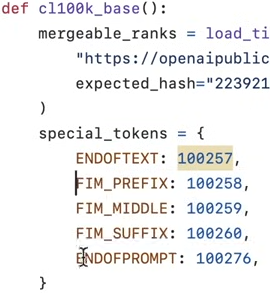